In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
from torch.utils.data import Dataset
import requests

from time import time

from pytorch_lightning.loggers import WandbLogger

from typing import Tuple, List

from sklearn.model_selection import train_test_split

/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
class NamesDataset(Dataset):
    def __init__(self, names: List[str], block_size: int = 3) -> None:
        self._data = names
        self._block_size = block_size

        chars = sorted(list(set("".join(self._data))))
        self._stoi = {s:i+1 for i,s in enumerate(chars)}
        self._stoi["."] = 0
        self._itos = {i:s for s,i in self._stoi.items()}

        self._X, self._Y = self._parse_dataset()

    def _parse_dataset(self) -> Tuple[List[int], List[int]]:
        X, Y = [], []
        for w in self._data:
            context = [0] * self._block_size
            for ch in w + '.':
                ix = self._stoi[ch]
                X.append(context)
                Y.append(ix)
                context = context[1:] + [ix]
        return X, Y

    def __len__(self) -> int:
        return len(self._Y)
    
    def __getitem__(self, idx: int) -> Tuple[torch.tensor, torch.tensor]:
        return torch.tensor(self._X[idx]), torch.tensor(self._Y[idx])

In [10]:
class NiceNameMLP(pl.LightningModule):
	def __init__(
			self,
			class_size: int = 27,
			emb_size: int = 2,
			block_size: int = 3,
			hidden_size: int = 100
		) -> None:
		super().__init__()

		self.model_params = {
			"class_size": class_size,
			"emb_size": emb_size,
			"block_size": block_size,
		}

		self.C = torch.nn.Embedding(class_size, emb_size)
		self.h1 = torch.nn.Linear(block_size * emb_size, hidden_size)
		self.a1 = torch.nn.Tanh()
		self.h2 = torch.nn.Linear(hidden_size, class_size)
		
	def forward(self, x):
		x = self.C(x) # <- retrieve embeddings
		x = self.h1(x.view(-1, self.model_params["block_size"] * self.model_params["emb_size"])) # <- emb * W1 + b1
		x = self.a1(x) # <- tanh(x)
		x = self.h2(x) # <- x * W2 + b2

		return x

	def configure_optimizers(self):
		optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
		return optimizer

	def training_step(self, train_batch, batch_idx):
		x, y = train_batch
		logits = self.forward(x)
		loss = F.cross_entropy(logits, y)
		self.log("train_loss", loss)
		return loss

	def validation_step(self, val_batch, batch_idx):
		x, y = val_batch
		logits = self.forward(x)
		loss = F.cross_entropy(logits, y)
		self.log("val_loss", loss)

In [11]:
dataset = requests.get("https://raw.githubusercontent.com/karpathy/makemore/master/names.txt").text.splitlines()

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
test_dataset, val_dataset = train_test_split(test_dataset, test_size=0.5, random_state=42)

In [23]:
BLOCK_SIZE = 3

train_loader = DataLoader(NamesDataset(train_dataset, block_size=BLOCK_SIZE), batch_size=256)
val_loader = DataLoader(NamesDataset(val_dataset, block_size=BLOCK_SIZE), batch_size=256, shuffle=False)
test_loader = DataLoader(NamesDataset(test_dataset, block_size=BLOCK_SIZE), batch_size=256, shuffle=False)

In [24]:
model = NiceNameMLP(block_size=BLOCK_SIZE)

In [25]:
wandb_logger = WandbLogger(project="codeacademy1", name=f"nice_mlp_{int(time())}", log_model=True)

for key, value in model.model_params.items():
    wandb_logger.experiment.config[key] = value

wandb_logger.experiment.config["batch_size"] = 256

/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [27]:
trainer = pl.Trainer(max_epochs=10, logger=wandb_logger, default_root_dir="checkpoints/")
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory ./codeacademy1/rmlsu60p/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name | Type      | Params
-----------------------------------
0 | C    | Embedding | 54    
1 | h1   | Linear    | 700   
2 | a1   | Tanh      | 0     
3 | h2   | Linear    | 2.7 K 
-----------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     

/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 802/802 [00:05<00:00, 158.34it/s, loss=2.25, v_num=u60p]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 802/802 [00:05<00:00, 158.15it/s, loss=2.25, v_num=u60p]


In [87]:

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl

class LitAutoEncoder(pl.LightningModule):
	def __init__(self):
		super().__init__()
		self.encoder = nn.Sequential(
      nn.Linear(28 * 28, 64),
      nn.ReLU(),
      nn.Linear(64, 3))
		
		self.decoder = nn.Sequential(
      nn.Linear(3, 64),
      nn.ReLU(),
      nn.Linear(64, 28 * 28))

	def forward(self, x):
		embedding = self.encoder(x)
		return embedding

	def configure_optimizers(self):
		optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
		return optimizer

	def training_step(self, train_batch, batch_idx):
		x, y = train_batch
		x = x.view(x.size(0), -1)
		z = self.encoder(x)    
		x_hat = self.decoder(z)
		loss = F.mse_loss(x_hat, x)
		self.log('train_loss', loss)
		return loss

	def validation_step(self, val_batch, batch_idx):
		x, y = val_batch
		x = x.view(x.size(0), -1)
		z = self.encoder(x)
		x_hat = self.decoder(z)
		loss = F.mse_loss(x_hat, x)
		self.log('val_loss', loss)

# data
dataset = MNIST('', train=True, download=True, transform=transforms.ToTensor())
mnist_train, mnist_val = random_split(dataset, [55000, 5000])

train_loader = DataLoader(mnist_train, batch_size=32)
val_loader = DataLoader(mnist_val, batch_size=32)

# model
model = LitAutoEncoder()
# training
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.4 K
1 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1876/1876 [00:12<00:00, 150.09it/s, loss=0.039, v_num=11] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1876/1876 [00:12<00:00, 150.03it/s, loss=0.039, v_num=11]


In [88]:
x = [i for i in DataLoader(mnist_train, batch_size=1)]

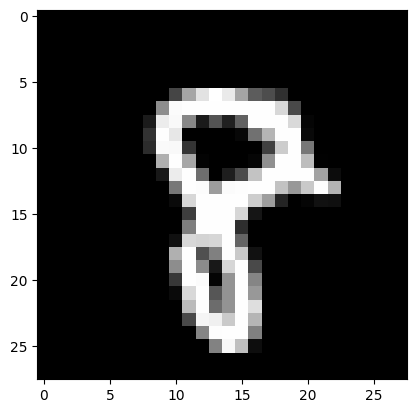

In [93]:
from matplotlib import pyplot as plt

plt.imshow(x[3][0].view(28, 28).tolist(), cmap="gray")

In [94]:
embs = model(x[3][0].view(28 * 28))

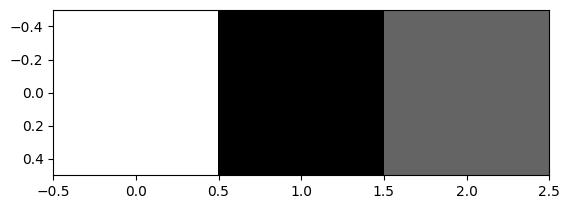

In [95]:
plt.imshow(embs.view(1, 3).tolist(), cmap="gy")

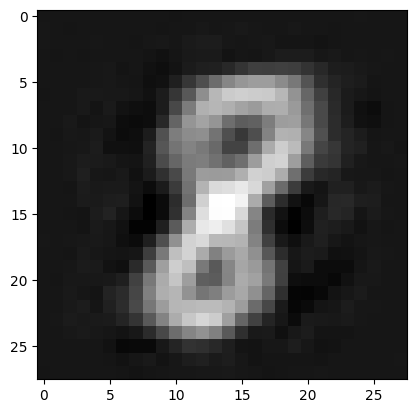

In [96]:
plt.imshow(model.decoder(embs).view(28, 28).tolist(), cmap="gray")

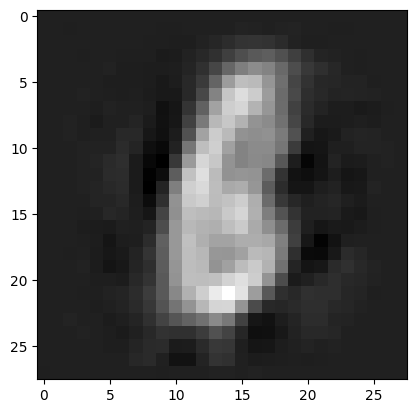

In [111]:
plt.imshow(model.decoder(embs * 0.3).view(28, 28).tolist(), cmap="gray")